# RNAseq PCA

Notebook for performing PCA on the feature count files.

2020-09-14

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Python-dotenv could not parse statement starting at line 1


Standard variables loaded, you are good to go!


## 1. Loading data

We load the outputs from featureCounts:

In [2]:
import pandas as pd

data_file_names = []
data_file_names.append("featureCounts_on_Control1.tabular")
data_file_names.append("featureCounts_on_Control4.tabular")
data_file_names.append("featureCounts_on_Control5.tabular")
data_file_names.append("featureCounts_on_KCl2.tabular")
data_file_names.append("featureCounts_on_KCl3.tabular")
data_file_names.append("featureCounts_on_KCl4.tabular")
data_file_names.append("featureCounts_on_NaCl1.tabular")
data_file_names.append("featureCounts_on_NaCl2.tabular")
data_file_names.append("featureCounts_on_NaCl3.tabular")

feature_counts = pd.DataFrame()
for data_file_name in data_file_names:
    full_name = join(INTERMEDIATE,data_file_name)
    new_data = pd.read_csv(full_name, index_col=0, sep="\t")
    new_data.columns = [new_data.columns[0].replace("RNA STAR on ","").replace(": mapped.bam","")]
    if feature_counts.empty:
        feature_counts = new_data
    else:
        feature_counts = pd.merge(feature_counts, new_data, left_index=True, right_index=True)
feature_counts

,Control1,Control4,Control5,1MKCl2,1MKCl3,1MKCl4,1MNaCl1,1MNaCl2,1MNaCl3
Geneid,,,,,,,,,
gene-DEHA2A00110g,172,557,487,44,71,18,85,75,72
gene-DEHA2A00132g,54,227,188,30,30,17,54,53,44
gene-DEHA2A00154g,17157,20856,19692,17471,24301,10478,19806,20211,16215
gene-DEHA2A00176g,107,143,97,94,102,99,86,75,99
gene-DEHA2A00198g,284,417,431,351,519,392,584,506,521
...,...,...,...,...,...,...,...,...,...
rna-NC_010166.1:25973..26055,0,0,0,0,0,0,0,0,0
rna-NC_010166.1:26058..26137,0,0,0,0,0,0,0,0,0
rna-NC_010166.1:27648..27719,0,0,0,0,0,0,0,0,0


## 2. Data normalization

We will transform the read counts to reads per kilobase (RPK), i.e. normalizing by gene length (in kilobase):

In [3]:
# load gene length data
import csv
with open(join(RAW_EXTERNAL,"gene_length.tabular"), mode='r') as infile:
    reader = csv.reader(infile, delimiter="\t")
    gene_length = {rows[0]:int(rows[1])/1000 for rows in reader}  # we divide by 1000 to get kilobase

# normalize by gene length
to_delete = []
for (idx, row) in feature_counts.iterrows():
    try:
        gene_id = idx.replace("gene-", "")
        feature_counts.loc[idx, :] = row/gene_length[gene_id]
    except:
        print(f"Could not match {idx}")
        to_delete.append(idx)

# drop rows without gene length (i.e. not available in the reference genome)
feature_counts = feature_counts.drop(to_delete)
feature_counts

Could not match gene-DEHA2A07898r
Could not match gene-DEHA2B02662r
Could not match gene-DEHA2C09790r
Could not match gene-DEHA2D10846r
Could not match gene-DEHA2D15774r
Could not match gene-DEHA2D16852r
Could not match gene-DEHA2E15818r
Could not match gene-DEHA2F21296r
Could not match gene-DEHA2G09746r
Could not match rna-NC_010166.1:2480..2551
Could not match rna-NC_010166.1:3329..3399
Could not match rna-NC_010166.1:12797..12867
Could not match rna-NC_010166.1:13006..13077
Could not match rna-NC_010166.1:13228..13308
Could not match rna-NC_010166.1:13310..13381
Could not match rna-NC_010166.1:13444..13515
Could not match rna-NC_010166.1:14490..14560
Could not match rna-NC_010166.1:14558..14630
Could not match rna-NC_010166.1:14642..14714
Could not match rna-NC_010166.1:14714..14794
Could not match rna-NC_010166.1:14799..14870
Could not match rna-NC_010166.1:18498..18570
Could not match rna-NC_010166.1:18652..18722
Could not match rna-NC_010166.1:18772..18843
Could not match rna-NC_

,Control1,Control4,Control5,1MKCl2,1MKCl3,1MKCl4,1MNaCl1,1MNaCl2,1MNaCl3
Geneid,,,,,,,,,
gene-DEHA2A00110g,40.710059,131.834320,115.266272,10.414201,16.804734,4.260355,20.118343,17.751479,17.041420
gene-DEHA2A00132g,44.153720,185.609158,153.720360,24.529845,24.529845,13.900245,44.153720,43.336059,35.977105
gene-DEHA2A00154g,16497.115385,20053.846154,18934.615385,16799.038462,23366.346154,10075.000000,19044.230769,19433.653846,15591.346154
gene-DEHA2A00176g,504.716981,674.528302,457.547170,443.396226,481.132075,466.981132,405.660377,353.773585,466.981132
gene-DEHA2A00198g,871.165644,1279.141104,1322.085890,1076.687117,1592.024540,1202.453988,1791.411043,1552.147239,1598.159509
...,...,...,...,...,...,...,...,...,...
gene-DEHA2G25080g,4.132231,0.000000,8.264463,41.322314,8.264463,4.132231,33.057851,8.264463,24.793388
gene-DEHA2G25102g,7.025761,9.367681,12.880562,21.077283,22.248244,16.393443,25.761124,25.761124,19.906323
gene-DEHA2G25124g,51.080550,17.681729,23.575639,23.575639,56.974460,55.009823,174.852652,15.717092,300.589391


## 3. PCA

Our variables will be each gene and our observations each condition:

In [4]:
# transpose data (variables should be the genes)
feature_counts = feature_counts.transpose()
feature_counts

Geneid,gene-DEHA2A00110g,gene-DEHA2A00132g,gene-DEHA2A00154g,gene-DEHA2A00176g,gene-DEHA2A00198g,gene-DEHA2A00220g,gene-DEHA2A00242g,gene-DEHA2A00264g,gene-DEHA2A00286g,gene-DEHA2A00308g,...,gene-DEHA2G24970g,gene-DEHA2G24992g,gene-DEHA2G25014g,gene-DEHA2G25036g,gene-DEHA2G25058g,gene-DEHA2G25080g,gene-DEHA2G25102g,gene-DEHA2G25124g,gene-LSU,gene-SSU
Control1,40.710059,44.153720,16497.115385,504.716981,871.165644,413.054564,782.518210,715.758468,4542.268041,1365.0,...,258.272454,43.636364,3799.170124,2751.798561,0.000000,4.132231,7.025761,51.080550,216.010165,194.814815
Control4,131.834320,185.609158,20053.846154,674.528302,1279.141104,451.300357,1148.283039,871.134021,4876.288660,1630.0,...,241.082939,69.090909,4624.896266,2057.553957,23.316062,0.000000,9.367681,17.681729,188.055909,185.185185
Control5,115.266272,153.720360,18934.615385,457.547170,1322.085890,596.124426,1238.293444,889.543446,8348.453608,1375.0,...,198.538891,120.000000,5200.829876,1866.906475,20.725389,8.264463,12.880562,23.575639,217.704363,171.851852
1MKCl2,10.414201,24.529845,16799.038462,443.396226,1076.687117,175.420704,409.469303,530.191458,4232.989691,1735.0,...,238.504512,120.000000,5237.344398,2068.345324,25.906736,41.322314,21.077283,23.575639,1405.760271,480.000000
1MKCl3,16.804734,24.529845,23366.346154,481.132075,1592.024540,286.078531,1176.899063,763.622975,4597.938144,1935.0,...,310.270735,76.363636,6397.510373,2093.525180,18.134715,8.264463,22.248244,56.974460,1057.179161,437.037037
1MKCl4,4.260355,13.900245,10075.000000,466.981132,1202.453988,191.228965,419.875130,465.390280,4301.030928,1020.0,...,177.911474,83.636364,4622.406639,2014.388489,5.181347,4.132231,16.393443,55.009823,45.743329,20.740741
1MNaCl1,20.118343,44.153720,19044.230769,405.660377,1791.411043,364.609893,1239.854318,821.796760,8127.835052,1400.0,...,284.056725,290.909091,7059.751037,1568.345324,31.088083,33.057851,25.761124,174.852652,941.973740,211.111111
1MNaCl2,17.751479,43.336059,19433.653846,353.773585,1552.147239,292.707802,871.488033,615.611193,4560.824742,1565.0,...,265.148260,207.272727,5723.651452,1615.107914,41.450777,8.264463,25.761124,15.717092,249.047014,92.592593
1MNaCl3,17.041420,35.977105,15591.346154,466.981132,1598.159509,362.060173,1311.654527,914.580265,6424.742268,1355.0,...,282.337774,214.545455,7318.672199,2028.776978,23.316062,24.793388,19.906323,300.589391,607.369759,245.925926


In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# normalize the data:
x = feature_counts.loc[:, ].values
x = StandardScaler().fit_transform(x)

# run PCA:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

#transform PCA results to dataframe
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
pca_df.index = feature_counts.index
groups = ["Control", "KCl", "NaCl"]
for (idx, row) in pca_df.iterrows():
    for group in groups:
        if group in idx:
            pca_df.loc[idx,"group"] = group
pca_df

,PC1,PC2,group
Control1,-22.822601,77.174467,Control
Control4,-44.201532,12.194560,Control
Control5,-68.135730,20.620502,Control
1MKCl2,82.473490,7.724736,KCl
1MKCl3,-23.875192,-25.039091,KCl
1MKCl4,88.982595,19.147441,KCl
1MNaCl1,-16.636346,-53.873287,NaCl
1MNaCl2,12.826731,-29.323207,NaCl
1MNaCl3,-8.611416,-28.626122,NaCl


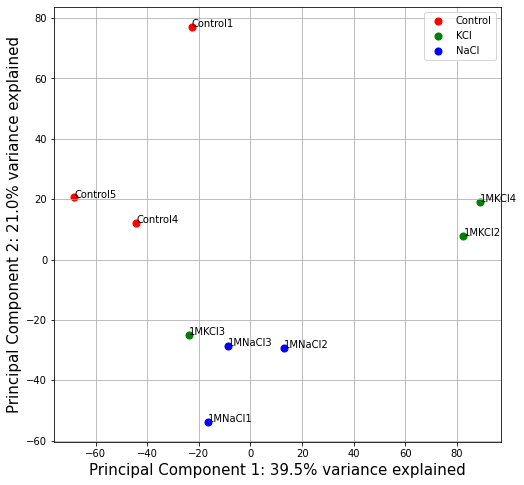

In [6]:
# get % of variability from each component
exp_var_1 = round(pca.explained_variance_ratio_[0]*100, 1)
exp_var_2 = round(pca.explained_variance_ratio_[1]*100, 1)

# plot results
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(f'Principal Component 1: {exp_var_1}% variance explained', fontsize = 15)
ax.set_ylabel(f'Principal Component 2: {exp_var_2}% variance explained', fontsize = 15)
colors = ['r', 'g', 'b']
for group, color in zip(groups,colors):
    to_keep = pca_df['group'] == group
    ax.scatter(pca_df.loc[to_keep, 'PC1'], pca_df.loc[to_keep, 'PC2'], c = color, s = 50)
ax.legend(groups)
for (idx, row) in pca_df.iterrows():
    ax.text(row["PC1"], row["PC2"], idx)
ax.grid()